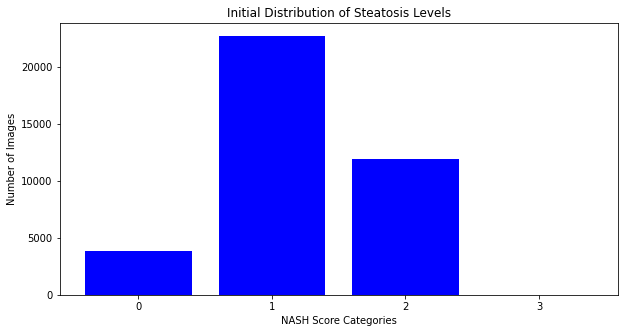

In [1]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def count_images_in_directory(directory):
    return {folder_name: len(os.listdir(os.path.join(directory, folder_name)))
            for folder_name in os.listdir(directory) if os.path.isdir(os.path.join(directory, folder_name))}

def plot_distribution(data, title):
    classes = sorted(data.keys())
    counts = [data[cls] for cls in classes]
    plt.figure(figsize=(10, 5))
    plt.bar(classes, counts, color='blue')
    plt.xlabel('NASH Score Categories')
    plt.ylabel('Number of Images')
    plt.title(title)
    plt.show()

data_dir = "D:/DATASET/CNN/steatosis/train" # Adjust this path
original_counts = count_images_in_directory(data_dir)
plot_distribution(original_counts, 'Initial Distribution of Steatosis Levels')

In [2]:
balanced_data_dir = 'D:/DATASET/CNN/steatosis/balanced_data'
target_samples = 4000

# Create directories if they don't exist
os.makedirs(balanced_data_dir, exist_ok=True)
for i in range(4):  # Assuming class labels are 0, 1, 2, 3
    os.makedirs(os.path.join(balanced_data_dir, str(i)), exist_ok=True)

# Data augmentation configuration
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255
)

# Augment and balance data
def augment_and_balance(class_id, current_count):
    generator = datagen.flow_from_directory(
        directory=data_dir,
        classes=[str(class_id)],
        target_size=(299, 299),
        batch_size=32,
        class_mode='categorical',
        save_to_dir=os.path.join(balanced_data_dir, str(class_id)),
        save_prefix='aug',
        save_format='jpeg'
    )
    num_generated = 0
    while num_generated < target_samples - current_count:
        generator.next()
        num_generated += 32

for class_id, count in original_counts.items():
    if count < target_samples:
        augment_and_balance(class_id, count)


Found 3812 images belonging to 1 classes.
Found 19 images belonging to 1 classes.


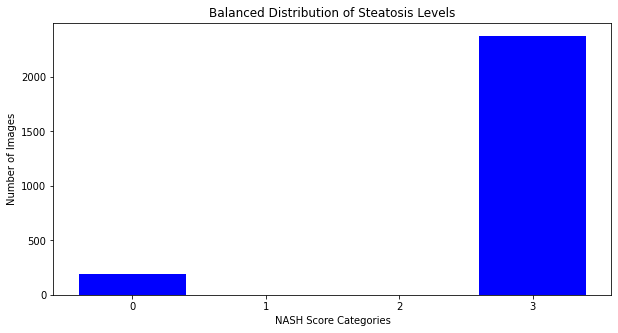

In [3]:
balanced_counts = count_images_in_directory(balanced_data_dir)
plot_distribution(balanced_counts, 'Balanced Distribution of Steatosis Levels')

In [4]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load and configure the ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=x)
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Load data from balanced dataset
train_generator = datagen.flow_from_directory(
    balanced_data_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical'
)

# Train the model
history = model.fit(train_generator, epochs=5)

# Save the model
model.save('D:/DATASET/Models/model_steatosis.h5')

Found 2567 images belonging to 4 classes.
Epoch 1/5
81/81 [==============================] - 1150s 14s/step - loss: 0.1605 - accuracy: 0.9735
Epoch 2/5
 7/81 [=>............................] - ETA: 17:00 - loss: 0.0503 - accuracy: 0.9911

KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

def predict_new_image(image_path, model_path="D:/DATASET/Models/model_steatosis.h5"):
    # Load the model
    model = load_model(model_path)

    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(299, 299))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Create a batch
    img_array /= 255.0  # Rescale the image

    # Predict the steatosis level
    probabilities = model.predict(img_array)
    predicted_class = np.argmax(probabilities)

    # Show image and prediction
    plt.imshow(img)
    plt.title(f'Predicted Steatosis Level: {predicted_class}')
    plt.axis('off')
    plt.show()

    return predicted_class

image_path = "D:/DATASET/CNN/steatosis/train/1/2_158_71.png"
predicted_class = predict_new_image(image_path)